<a href="https://colab.research.google.com/github/nicolapitzalis/quick-pattern-recognition/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Restricted Boltzmann Machines for Discriminative Tasks
In the following, we are going to implement a simple RBM architecture, to then exploit ist representative power to perform classification on the famous MNIST dataset.



## Preparation

### Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import struct
from sklearn.linear_model import LinearRegression, LogisticRegression

### Load the Dataset

In [ ]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Paths to the files
train_image_file = '/content/drive/MyDrive/datasets/mnist/train-images.idx3-ubyte'
train_label_file = '/content/drive/MyDrive/datasets/mnist/train-labels.idx1-ubyte'
test_image_file = '/content/drive/MyDrive/datasets/mnist/t10k-images.idx3-ubyte'
test_label_file = '/content/drive/MyDrive/datasets/mnist/t10k-labels.idx1-ubyte'

# Read the files
train_images = read_idx(train_image_file)
train_labels = read_idx(train_label_file)
test_images = read_idx(test_image_file)
test_labels = read_idx(test_label_file)

train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

## Implementing the RBM

In [ ]:
class RBM:

    def __init__(self, n_visible, n_hidden, learning_rate):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = np.random.randn(n_visible, n_hidden) * 0.01
        self.bias_hidden = np.zeros(n_hidden)
        self.bias_visible = np.zeros(n_visible)

    def _logistic(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_from_p(self, p):
        # Bernoulli sampling from a distribution p
        return (p > np.random.rand(*p.shape)).astype(np.float32)

    def sample_from_h(self, v):
        # Compute probabilities and sample hidden states
        p_h = self._logistic(np.dot(v, self.weights) + self.bias_hidden)
        sample_h = self.sample_from_p(p_h)
        return p_h, sample_h

    def sample_from_v(self, h):
        # Compute probabilities and sample visible states
        p_v = self._logistic(np.dot(h, self.weights.T) + self.bias_visible)
        sample_v = self.sample_from_p(p_v)
        return p_v, sample_v

    def cd_1(self, data, batch_size, max_epoch):
        num_samples = data.shape[0]

        for epoch in range(max_epoch):
            epoch_error = 0.0

            for i in range(0, num_samples, batch_size):
                # Get the batch
                v = data[i:i+batch_size]
                binary_v = self.sample_from_p(v)

                # Contrastive divergence
                p_h, sample_h = self.sample_from_h(binary_v)
                p_v, sample_v = self.sample_from_v(sample_h)
                p_h1, _ = self.sample_from_h(sample_v)

                # Compute the gradients
                positive_phase = np.dot(binary_v.T, p_h)
                negative_phase = np.dot(sample_v.T, p_h1)

                # Update weights and biases
                self.weights += self.learning_rate * (positive_phase - negative_phase) / batch_size
                self.bias_hidden += self.learning_rate * np.mean(p_h - p_h1, axis=0)
                self.bias_visible += self.learning_rate * np.mean(v - sample_v, axis=0)

                # Calculate error
                epoch_error += np.mean((binary_v - sample_v) ** 2)

            epoch_error /= num_samples
            print(f'Epoch: {epoch} \t Error: {epoch_error}')


## Training the RBM and Classification Task
Note that the images' matrices will be flattened into single vectors of 28x28 in order to feed the RBM.

### The classification Task
To understand whether our hidden representation is meaningful we choose very simple classifiers. For this reason, we explore both the linear regressor and the logistic regressor.

Also, given the balancing of both the training and test set, we'll use Accuracy as the performance measure.

In [ ]:
unique_classes, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique_classes, counts)))

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [ ]:
unique_classes, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_classes, counts)))

{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


### Training with 500 hidden units


In [ ]:
n_visible = 28 * 28  # Number of pixels in each image

In [ ]:
n_hidden = 500

rbm = RBM(n_visible, n_hidden, learning_rate=0.1)

# flatten the images
train_flattened_images = train_images.reshape(-1, 28*28)
test_flattened_images = test_images.reshape(-1, 28*28)

# train the RBM
rbm.cd_1(train_flattened_images, batch_size=64, max_epoch=20)

Epoch: 0 	 Error: 0.0014281137069066365
Epoch: 1 	 Error: 0.0010045772211626173
Epoch: 2 	 Error: 0.0008957898202041785
Epoch: 3 	 Error: 0.0008351612309614818
Epoch: 4 	 Error: 0.0007972280903408925
Epoch: 5 	 Error: 0.0007702454028030237
Epoch: 6 	 Error: 0.000749874441511929
Epoch: 7 	 Error: 0.0007344919219613075
Epoch: 8 	 Error: 0.0007234946330388387
Epoch: 9 	 Error: 0.0007133848850925763
Epoch: 10 	 Error: 0.0007047263635943334
Epoch: 11 	 Error: 0.0006970145088310043
Epoch: 12 	 Error: 0.0006923190378273526
Epoch: 13 	 Error: 0.0006856734292581678
Epoch: 14 	 Error: 0.000680821176369985
Epoch: 15 	 Error: 0.0006774779455115397
Epoch: 16 	 Error: 0.0006741091359406709
Epoch: 17 	 Error: 0.0006705499978115161
Epoch: 18 	 Error: 0.0006675708173463742
Epoch: 19 	 Error: 0.0006650124885141849


Once the training has ended, we use the RBM to encode both the training and test set, in order to have a more powerful representation of the data that we'll use for the classification task.

#### Encoding and Reconstruction
We'll have a look at what the reconstructed images look like using the trained RBM. For this, we will use some selected images from the test set.

We'll plot both the binary reconstructed images (sampling the visible probability distribution) and the normalized reconstructed images (scaling the probability distribution back to gray scale)

In [ ]:
og_images = []
og_images.append(test_flattened_images[3])
og_images.append(test_flattened_images[2])
og_images.append(test_flattened_images[1])
og_images.append(test_flattened_images[30])
og_images.append(test_flattened_images[4])
og_images.append(test_flattened_images[15])
og_images.append(test_flattened_images[8])
og_images.append(test_flattened_images[0])
og_images.append(test_flattened_images[61])
og_images.append(test_flattened_images[7])

reshaped_images = []
for im in og_images:
    reshaped_images.append(im.reshape(28, 28))

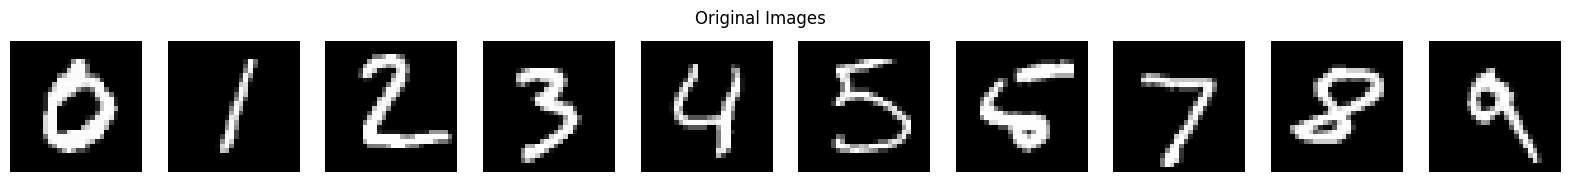

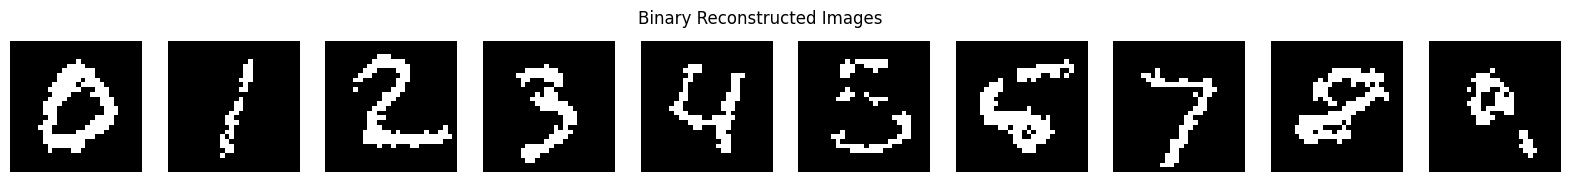

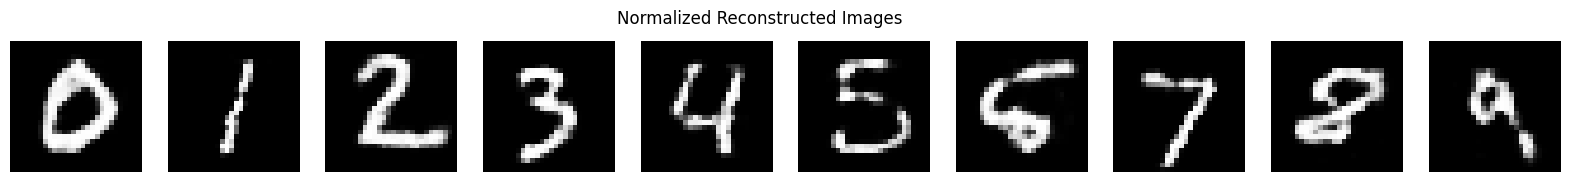

In [ ]:
binary_recon_images = []
normalized_recon_images = []

for im in og_images:
    bin_image = rbm.sample_from_p(im)
    _, sample_h = rbm.sample_from_h(bin_image)
    p_v, sample_v = rbm.sample_from_v(sample_h)
    v_normalized = p_v * 255    # to scale back to gray scale from the p

    binary_recon_images.append(sample_v.astype(int).reshape(28, 28))
    normalized_recon_images.append(v_normalized.astype(int).reshape(28,28))

fig, axes = plt.subplots(nrows=1, ncols=len(reshaped_images), figsize=(20, 2))
fig.suptitle("Original Images")
for ax, image in zip(axes, reshaped_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(binary_recon_images), figsize=(20, 2))
fig.suptitle("Binary Reconstructed Images")
for ax, image in zip(axes, binary_recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(binary_recon_images), figsize=(20, 2))
fig.suptitle("Normalized Reconstructed Images")
for ax, image in zip(axes, normalized_recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

Now the entire training and test sets will be encoded to train our classifier.

In [ ]:
encoded_X = []

for x in train_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(binary_x)[1])

X_train = np.array(encoded_X)
y_train = train_labels

In [ ]:
encoded_X = []

for x in test_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(binary_x)[1])

X_test = np.array(encoded_X)
y_test = test_labels

#### Regression

In [ ]:
clf = LinearRegression().fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.6920141354386918

As one could expect, a linear regressor does not perform magnificently on the classification task at end, but still the results are not bad at all.

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.9269

The logistic regressor performs way better than the linear one, achieving an interesting performance result.

## More Trials
In the following we'll explore some more configurations of hyperparameters, especially the number of the hidden neurons.

### Training with 100 hidden units

In [ ]:
n_hidden = 100

rbm = RBM(n_visible, n_hidden, learning_rate=0.1)

# Flatten the images
train_flattened_images = train_images.reshape(-1, 28*28)
test_flattened_images = test_images.reshape(-1, 28*28)

# Train the RBM
rbm.cd_1(train_flattened_images, batch_size=64, max_epoch=20)

Epoch: 0 	 Error: 0.001755820510412256
Epoch: 1 	 Error: 0.001319522946452101
Epoch: 2 	 Error: 0.001219614290446043
Epoch: 3 	 Error: 0.0011653210704525312
Epoch: 4 	 Error: 0.0011277722431346775
Epoch: 5 	 Error: 0.0011013283254578709
Epoch: 6 	 Error: 0.001079243730319043
Epoch: 7 	 Error: 0.0010619794979070624
Epoch: 8 	 Error: 0.0010480575051779548
Epoch: 9 	 Error: 0.0010348526518171033
Epoch: 10 	 Error: 0.00102510994579643
Epoch: 11 	 Error: 0.0010159973534444968
Epoch: 12 	 Error: 0.001008615007189413
Epoch: 13 	 Error: 0.0010033877419307828
Epoch: 14 	 Error: 0.000996188084470729
Epoch: 15 	 Error: 0.0009916762975975871
Epoch: 16 	 Error: 0.000986001608458658
Epoch: 17 	 Error: 0.0009834286648159225
Epoch: 18 	 Error: 0.0009797340031713246
Epoch: 19 	 Error: 0.0009765086905409893


#### Encoding and Reconstruction


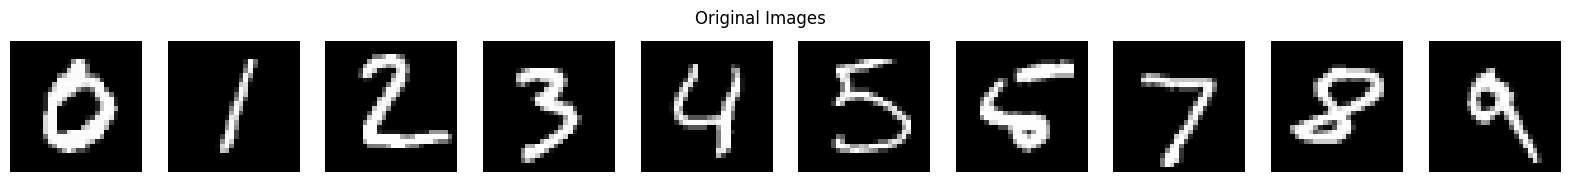

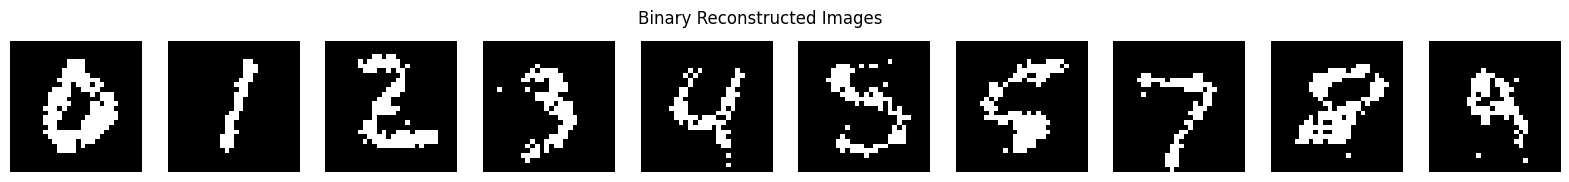

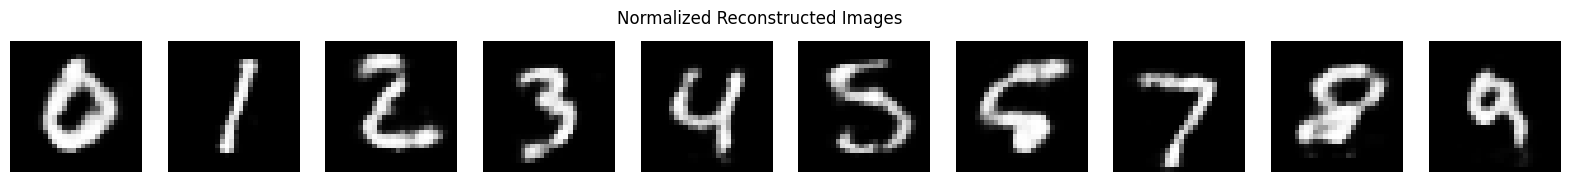

In [ ]:
binary_recon_images = []
normalized_recon_images = []

for im in og_images:
    bin_image = rbm.sample_from_p(im)
    _, sample_h = rbm.sample_from_h(bin_image)
    p_v, sample_v = rbm.sample_from_v(sample_h)
    v_normalized = p_v * 255    # to scale back to gray scale from the p

    binary_recon_images.append(sample_v.astype(int).reshape(28, 28))
    normalized_recon_images.append(v_normalized.astype(int).reshape(28,28))

fig, axes = plt.subplots(nrows=1, ncols=len(reshaped_images), figsize=(20, 2))
fig.suptitle("Original Images")
for ax, image in zip(axes, reshaped_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(binary_recon_images), figsize=(20, 2))
fig.suptitle("Binary Reconstructed Images")
for ax, image in zip(axes, binary_recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(binary_recon_images), figsize=(20, 2))
fig.suptitle("Normalized Reconstructed Images")
for ax, image in zip(axes, normalized_recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

Even thoug the accuracy did not change too much, we can see how the reconstructed images are a bit less clear than those produced by the RBM trained on 500 hidden units.

In [ ]:
encoded_X = []

for x in train_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(x)[1])

X_train = np.array(encoded_X)
y_train = train_labels

In [ ]:
encoded_X = []

for x in test_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(x)[1])

X_test = np.array(encoded_X)
y_test = test_labels

#### Regression

In [ ]:
clf = LinearRegression().fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.6309856172715916

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.9124

As we can observe, decreasing the number of hidden neurons up to 100 (from the initial 500) does not pertain a significant decrease in the accuracy score of the classifier.
For this reason, we'll also explore a smaller RBM od 30 units.

### Training with 30 hidden units

In [ ]:
n_visible = 28 * 28  # Number of pixels in each image
n_hidden = 30

rbm = RBM(n_visible, n_hidden, learning_rate=0.1)

# Flatten the images
train_flattened_images = train_images.reshape(-1, 28*28)
test_flattened_images = test_images.reshape(-1, 28*28)

# Train the RBM
rbm.cd_1(train_flattened_images, batch_size=64, max_epoch=20)

Epoch: 0 	 Error: 0.0021509353760629894
Epoch: 1 	 Error: 0.001721699617927273
Epoch: 2 	 Error: 0.001643975540002187
Epoch: 3 	 Error: 0.001610037668546041
Epoch: 4 	 Error: 0.0015889575341095528
Epoch: 5 	 Error: 0.0015743399905661741
Epoch: 6 	 Error: 0.0015635669102271397
Epoch: 7 	 Error: 0.00155846254453063
Epoch: 8 	 Error: 0.0015520328434805075
Epoch: 9 	 Error: 0.0015489041917026043
Epoch: 10 	 Error: 0.0015432667004565397
Epoch: 11 	 Error: 0.0015412494687984386
Epoch: 12 	 Error: 0.001535518973444899
Epoch: 13 	 Error: 0.001535346248249213
Epoch: 14 	 Error: 0.0015305597634365162
Epoch: 15 	 Error: 0.0015277685878177483
Epoch: 16 	 Error: 0.0015251029677689075
Epoch: 17 	 Error: 0.0015224964792529742
Epoch: 18 	 Error: 0.0015206111151725055
Epoch: 19 	 Error: 0.0015180707243581614


#### Encoding and Reconstruction


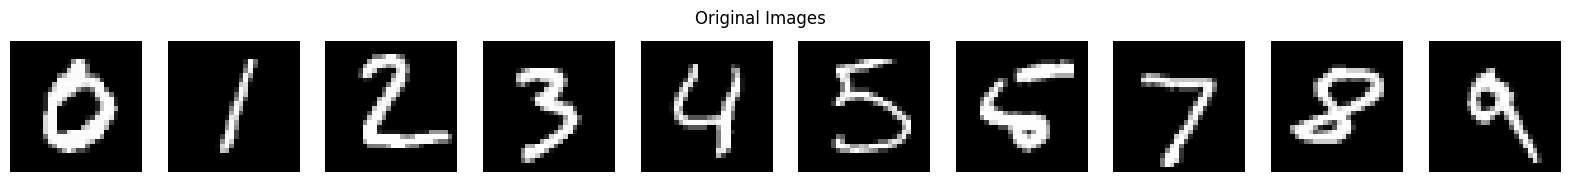

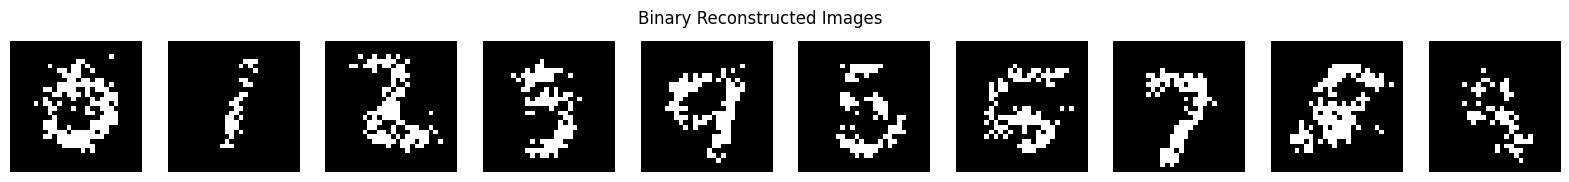

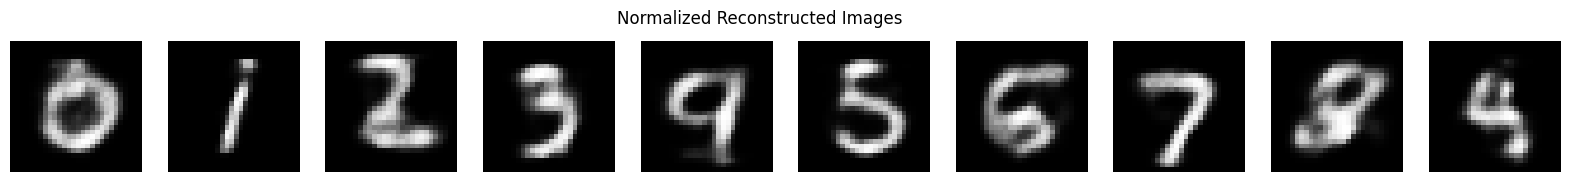

In [ ]:
binary_recon_images = []
normalized_recon_images = []

for im in og_images:
    bin_image = rbm.sample_from_p(im)
    _, sample_h = rbm.sample_from_h(bin_image)
    p_v, sample_v = rbm.sample_from_v(sample_h)
    v_normalized = p_v * 255    # to scale back to gray scale from the p

    binary_recon_images.append(sample_v.astype(int).reshape(28, 28))
    normalized_recon_images.append(v_normalized.astype(int).reshape(28,28))

fig, axes = plt.subplots(nrows=1, ncols=len(reshaped_images), figsize=(20, 2))
fig.suptitle("Original Images")
for ax, image in zip(axes, reshaped_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(binary_recon_images), figsize=(20, 2))
fig.suptitle("Binary Reconstructed Images")
for ax, image in zip(axes, binary_recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(binary_recon_images), figsize=(20, 2))
fig.suptitle("Normalized Reconstructed Images")
for ax, image in zip(axes, normalized_recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

As we can see, the reconstruction isn't really too precise using only 30 hidden units, particularly the 4 and 9 are undistinguishable.

In [ ]:
encoded_X = []

for x in train_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(x)[1])

X_train = np.array(encoded_X)
y_train = train_labels

In [ ]:
encoded_X = []

for x in test_flattened_images:
    binary_x = rbm.sample_from_p(x)
    encoded_X.append(rbm.sample_from_h(x)[1])

X_test = np.array(encoded_X)
y_test = test_labels

#### Regression

In [ ]:
clf = LinearRegression().fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.5431816862962191

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial').fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.8494

Using 30 hidden neurons seems to underperform quite noticeably w.r.t. the 100-neurons RBM.

## Experimenting with Gaussian Visible RBMs

Referencing [1] (Section 14.5.1) –when the book arguments about RBM being equivalent to denoising autoencoders under certain conditions– it was interesting to see how a RBM with gaussian visible (the normalized images) would have behaved. For this very reason, the experiment was carried on.

Note that the name of GaussianRBM isn't probably very representative of the model and might be ambiguous in unspecified contexts. Here the term "Gaussian" only refer to the distribution of the visible units.

In [ ]:
class GaussianRBM:

    def __init__(self, n_visible, n_hidden, learning_rate):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = np.random.randn(n_visible, n_hidden) * 0.01
        self.bias_hidden = np.zeros(n_hidden)
        self.bias_visible = np.zeros(n_visible)

    def _logistic(self, x):
        return 1 / (1 + np.exp(-x))

    def p_h_given_v(self, v):
        # no sampling has to occur
        p_h = self._logistic(np.dot(v, self.weights) + self.bias_hidden)
        return p_h

    def p_v_given_h(self, h):
        # no sampling has to occur
        p_v = self._logistic(np.dot(h, self.weights.T) + self.bias_visible)
        return p_v

    def cd_1(self, data, batch_size, max_epoch):
        num_samples = data.shape[0]

        for epoch in range(max_epoch):
            epoch_error = 0.0

            for i in range(0, num_samples, batch_size):
                # Get the batch
                v = data[i:i+batch_size]

                # Contrastive divergence
                p_h = self.p_h_given_v(v)
                p_v = self.p_v_given_h(p_h)
                p_h1 = self.p_h_given_v(p_v)

                # Compute the gradients
                positive_phase = np.dot(v.T, p_h)
                negative_phase = np.dot(p_v.T, p_h1)

                # Update weights and biases
                self.weights += self.learning_rate * (positive_phase - negative_phase) / batch_size
                self.bias_hidden += self.learning_rate * np.mean(p_h - p_h1, axis=0)
                self.bias_visible += self.learning_rate * np.mean(v - p_v, axis=0)

                # Calculate error
                epoch_error += np.mean((v - p_v) ** 2)

            epoch_error /= num_samples
            print(f'Epoch: {epoch} \t Error: {epoch_error}')


Keep in mind that in the code above we are not really doing any sampling, rather we just use the probabilities, not to add any noise.

In [ ]:
n_visible = 28 * 28  # Number of pixels in each image

In [ ]:
n_hidden = 500

gaussian_rbm = GaussianRBM(n_visible, n_hidden, learning_rate=0.1)

# flatten the images
train_flattened_images = train_images.reshape(-1, 28*28)
test_flattened_images = test_images.reshape(-1, 28*28)

# train the RBM
gaussian_rbm.cd_1(train_flattened_images, batch_size=64, max_epoch=20)

Epoch: 0 	 Error: 0.0003253994211918639
Epoch: 1 	 Error: 0.00012470032151669458
Epoch: 2 	 Error: 8.752844220769314e-05
Epoch: 3 	 Error: 7.026190089203217e-05
Epoch: 4 	 Error: 6.047414541260669e-05
Epoch: 5 	 Error: 5.4021639350546054e-05
Epoch: 6 	 Error: 4.939744253630341e-05
Epoch: 7 	 Error: 4.591751081306508e-05
Epoch: 8 	 Error: 4.3190151124640164e-05
Epoch: 9 	 Error: 4.0978854832821546e-05
Epoch: 10 	 Error: 3.913816035388145e-05
Epoch: 11 	 Error: 3.7573980708102e-05
Epoch: 12 	 Error: 3.622237201708542e-05
Epoch: 13 	 Error: 3.5038570447553634e-05
Epoch: 14 	 Error: 3.399036422508711e-05
Epoch: 15 	 Error: 3.305388622625783e-05
Epoch: 16 	 Error: 3.221102106493631e-05
Epoch: 17 	 Error: 3.144767229217675e-05
Epoch: 18 	 Error: 3.075258420166613e-05
Epoch: 19 	 Error: 3.0116575684901084e-05


### Encoding and Reconstruction


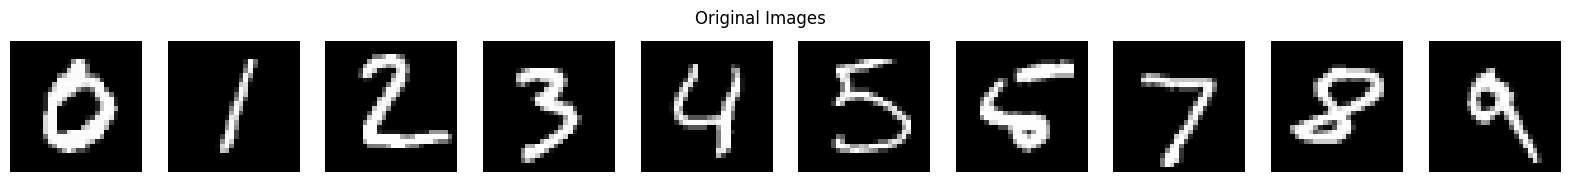

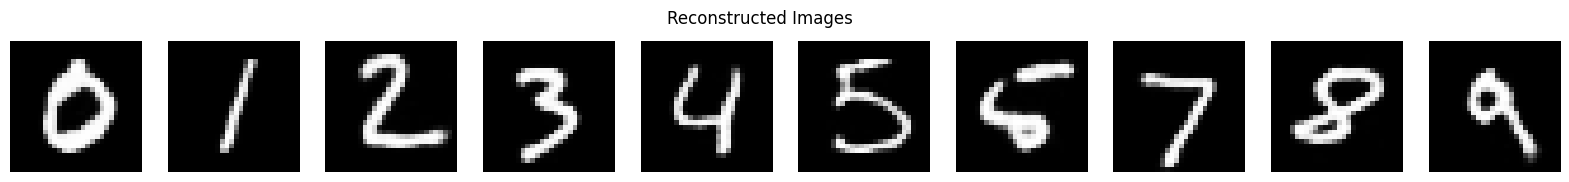

In [ ]:
recon_images = []

for im in og_images:
    p_h = gaussian_rbm.p_h_given_v(im)
    p_v = gaussian_rbm.p_v_given_h(p_h)
    v_scaled = p_v * 255    # to scale back to gray scale
    recon_images.append(v_scaled.astype(int).reshape(28, 28))

fig, axes = plt.subplots(nrows=1, ncols=len(reshaped_images), figsize=(20, 2))
fig.suptitle("Original Images")
for ax, image in zip(axes, reshaped_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=len(recon_images), figsize=(20, 2))
fig.suptitle("Reconstructed Images")
for ax, image in zip(axes, recon_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()

It is pretty interesting to see how the images are unrecognisable one another.

In [ ]:
encoded_X = []

for x in train_flattened_images:
    encoded_X.append(gaussian_rbm.p_h_given_v(x) * 255)    # to normalize in gray scale

X_train = np.array(encoded_X)
y_train = train_labels

In [ ]:
encoded_X = []

for x in test_flattened_images:
    encoded_X.append(gaussian_rbm.p_h_given_v(x) * 255) # to normalize in gray scale

X_test = np.array(encoded_X)
y_test = test_labels

### Regression

In [ ]:
clf = LinearRegression().fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.7635692637785194

In [ ]:
clf = LogisticRegression(solver='lbfgs', max_iter=2000, multi_class='multinomial').fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
clf.score(X_test, y_test)

0.9498

## Conclusion

In the first half of the notebook the RBM has been implemented and later trained with different parameters. To appreciate the quality of the distribution learned we plotted the reconstructed images for each of the chosen digit and also run a full evaluation on the MNIST test set.

In the second half, we shortly experimented a variation of the classical RBM, one with gaussian-distributed visible units. In the latter, no sampling has been adopted (in orther to avoid any sampling noise) giving a very easy and straightforward strategy to perform the cd_1 algorithm.

The curiosity to approach this laste experiment has been driven by the statement of Goodfellow-et-al for which a denoising autoencoder is equivalent to an RBM with gaussian visible variables, when trained with denoising score matching –which is not the case here. In any case Bengio-et-all, as cited in [1], showed that an autoencoder gradient provides an approximation to contrastive divergence training of RBMs.

## Personal Considerations

The task was fun. There is plenty of literature regarding RBMs and all possible connections to other models and applications in different fields.

It was also nice to appreciate how the model learns the distribution of the data in such a way that it is also able to reconstruct the input digit.

Nonetheless, experimenting with non-binary input variables extended the understanding of the model and made clearer the connection between different paradigms.

## References

[1] Ian Goodfellow, Yoshua Bengio, and Aaron Courville, *Deep Learning*, MIT Press, 2016. Available online: [Deep Learning Book](http://www.deeplearningbook.org).
